In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import os
import numpy as np
from matplotlib import pyplot as plt
set_seed(3407)

/Users/jasonvasquez/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
dataset = load_dataset("togethercomputer/RedPajama-Data-1T-Sample", 'plain_text', streaming=False, cache_dir='datasets')
dataset = dataset['train']

/Users/jasonvasquez/opt/anaconda3/envs/py311/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [5]:
# Custom dataset class for the Red Pajama dataset
class RedPajamaDataset(Dataset):
    def __init__(self, data, ul2=False, max_length=1024):
        self.data = data
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token_id = 50256
        self.new_tokens = [f'<new_id_{i}>' for i in range(400)]
        self.tokenizer.add_tokens(self.new_tokens)
        self.tokenizer.add_tokens(['[S2S] ', '[NLU] ', '[NLG] '])
        self.max_length =  max_length - 1
        self.vocab_size = len(self.tokenizer)
        self.ul2 = ul2
        self.token_dict = {'s': ('S2S', self.sequential_denoising), 'r': ('NLU', self.regular_denoising), 'x': ('NLG', self.extreme_denoising)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']

        if self.ul2:
            # Get the token to prepend and function to use.
            begin_id, func = self.token_dict[np.random.choice(['s', 'r', 'x'], size=1, p=[0.5, 0.25, 0.25])[0]]

            # Prepend token to string and tokenize
            text = begin_id + ' ' + text
            ids = self.tokenizer.encode(text, truncation=True, max_length=self.max_length, return_tensors='pt', add_special_tokens=True, padding=False)

            # Return the tokens
            return func(ids)
        else:
            # Tokenize the text
            tokens = self.tokenizer.encode(text, add_special_tokens=True, max_length=self.max_length, truncation=True, return_tensors='pt', padding=False)
            # Split the tokens into chunks of max_length
            # Shift the tokens to get targets (excluding the [CLS] token)
            target_tokens = tokens[:, 1:].clone()  # Exclude the [CLS] token
            tokens = tokens[:, :-1]  # Exclude the last token to match the shifted targets
            
            return tokens, target_tokens
        
    def regular_denoising(self, ids, corruption_pct=0.15, span_length=np.arange(2,6)):
        chance = (corruption_pct / np.mean(span_length)) * (1 + np.max(span_length) / len(ids))
        skip = 0
        new_tokens_used = 0
        targets = None

        for i in range(1, ids.shape[1]):
            if skip > 0:
                skip -= 1
                continue

            if np.random.random() < chance:
                mask_token = self.tokenizer.convert_tokens_to_ids(self.new_tokens[new_tokens_used])

                new_tokens_used += 1

                span = np.random.choice(span_length)

                #initialize targets if doesn't exist, otherwise update it
                if targets is None:
                    targets = torch.cat((torch.tensor([[mask_token]]), ids[:, i:i + span].clone()), dim=1)
                else:
                    targets = torch.cat((targets, torch.tensor([[mask_token]]), ids[:, i:i + span].clone()), dim=1)
                ids = torch.cat((ids[:, :i], torch.tensor([[mask_token]]), ids[:, i + span:]), dim=1)  # Mask the corrupted span in ids
                
                skip = span

        ids = torch.cat((ids, torch.tensor([[self.tokenizer.eos_token_id] * (self.max_length - ids.shape[1])])), dim=1)
        targets = torch.cat((targets, torch.tensor([[self.tokenizer.pad_token_id] * (self.max_length - targets.shape[1])])), dim=1)

        return ids, targets

    def sequential_denoising(self, ids):
        # Get the length of our input
        len_ids = ids.shape[1]


        # Normalize the probabilities and get the index to remove
        remove_index = np.random.choice(np.arange(len_ids // 2 - 15, len_ids // 2 + 15))

        # Get the token we are using for this space
        mask_token = self.tokenizer.convert_tokens_to_ids(self.new_tokens[0])

        # Get the tokens we are removing
        targets = torch.cat((torch.tensor([[mask_token]]), ids[:, remove_index:].clone()), dim=1)

        # Replace the tokens with the mask token
        ids = ids[:, :remove_index + 1].clone().detach()
        ids[:, -1] = mask_token

        #mask ids and targets to be desired length
        ids = torch.cat((ids, torch.tensor([[self.tokenizer.pad_token_id] * (self.max_length - ids.shape[1])])), dim=1)
        targets = torch.cat((targets, torch.tensor([[self.tokenizer.pad_token_id] * (self.max_length - targets.shape[1])])), dim=1)


        return ids, targets

    def extreme_denoising(self, ids, corruption_pct=0.50, span_length=np.arange(2,6)):
        return self.regular_denoising(ids, corruption_pct=corruption_pct, span_length=span_length)

# Create an instance of the custom dataset
red_pajama_dataset = RedPajamaDataset(dataset, ul2=True)
x, y = red_pajama_dataset[0]
print(x.shape, y.shape)

torch.Size([1, 1023]) torch.Size([1, 1023])


In [6]:
# load in an instance of the model
checkpoints = os.listdir('./checkpoints')
checkpoints.sort()

# create a GPT instance
red_pajama_dataset = RedPajamaDataset(dataset, ul2=True)
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset.vocab_size
model_config.block_size = red_pajama_dataset.max_length
model_config.checkpoint = None
# model_config.checkpoint = 'checkpoints/' + \
#     checkpoints[-1] if checkpoints else None  # This is a change
model_config.ul2 = True
model = GPT(model_config)

number of parameters: 2.57M
number of parameters: 2.57M


In [22]:
# create a GPT instance
red_pajama_dataset2 = RedPajamaDataset(dataset, ul2=False)
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset.vocab_size
model_config.block_size = red_pajama_dataset.max_length
model_config.checkpoint = None
# model_config.checkpoint = 'checkpoints/' + \
#     checkpoints[-1] if checkpoints else None  # This is a change
model_config.ul2 = False
model2 = GPT(model_config)

number of parameters: 2.57M


In [11]:
# create a Trainer object
from mingpt.trainer import Trainer

iters = 500

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = iters / 10     # This is a change
train_config.batch_size = 1
trainer = Trainer(train_config, model, red_pajama_dataset)

running on device cpu
running on device cpu


In [12]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 9.68943
iter_dt 901.37ms; iter 100: train loss 6.12530
iter_dt 852.68ms; iter 200: train loss 6.09763
iter_dt 862.57ms; iter 300: train loss 0.52653
iter_dt 963.75ms; iter 400: train loss 1.50218


In [23]:
iters = 500

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = iters / 10     # This is a change
train_config.batch_size = 1
trainer2 = Trainer(train_config, model2, red_pajama_dataset2)

running on device cpu


In [24]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer2.set_callback('on_batch_end', batch_end_callback)

trainer2.run()

iter_dt 0.00ms; iter 0: train loss 10.84540
iter_dt 648.18ms; iter 100: train loss 9.87855
iter_dt 110.79ms; iter 200: train loss 7.87452
iter_dt 120.28ms; iter 300: train loss 7.75261
iter_dt 581.05ms; iter 400: train loss 7.41933


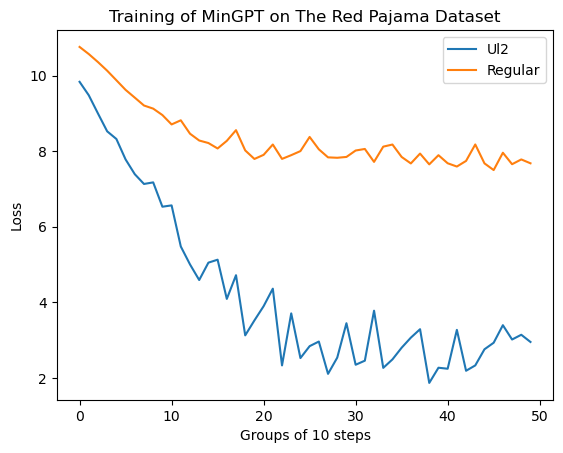

In [26]:
# Plot the loss
losses = trainer.curr_loss
losses2 = trainer2.curr_loss
x = 10
new_losses = np.mean(np.array(losses).reshape(-1, x), axis=1)
new_losses2 = np.mean(np.array(losses2).reshape(-1, x), axis=1)
plt.plot(np.arange(len(new_losses)), new_losses, label='Ul2')
plt.plot(np.arange(len(new_losses2)), new_losses2, label='Regular')
plt.title('Training of MinGPT on The Red Pajama Dataset')
plt.xlabel('Groups of 10 steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
model.eval();